In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import corner as corner 
sb.set_style('white')
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output

In [2]:
from model_DM_mu_P8R3 import * #change the model for mu or qq

In [3]:
def run_mcmc_status(sampler,init_pos,iterations,lnprob=None, rstate=None):
    count = 0
    for pos,prob,state in sampler.sample(init_pos,lnprob0=lnprob,rstate0=rstate,iterations=iterations):
        clear_output(wait=True)
        count += 1
        print('Current progress: ',np.round(count/iterations * 100.,2),'%')
        pass
    return pos,prob,state

In [4]:
path = '/Users/Oleg/Documents/O_Cen/O_cen_2D/P8R3/'

In [5]:
Ener,no_events,e_min,e_max = np.loadtxt(path + 'OC_no_events_15_bins_0.15_degree.txt',usecols=(0,1,2,3),unpack=True)

In [6]:
mask = no_events != 0.0
Ener = Ener[mask]
no_events = no_events[mask]
e_min = e_min[mask]
e_max = e_max[mask]
e_min = e_min/1000.
e_max = e_max/1000.

In [7]:
import scipy.optimize as op

In [8]:
fun = lambda *args: -lnhood2(*args)

In [9]:
mid = [10.,-10.0,-6.,1.5]
bnds = ((0.5,20.),(-20.,0.),(-20.,0.),(0.,5.))

result = op.minimize(fun,mid,args=(no_events,e_min,e_max),
                    method='TNC',bounds=bnds)
print(result.x)

[ 10.00263743 -10.00186136  -9.48666867   1.60348336]


In [10]:
p_list = [ 0.5,20.,-20.,0.,-20.,0.,0.,5.]
nwalkers = 160
ndim = int((len(p_list)/2))
z = np.zeros((ndim,nwalkers))

In [11]:
h = 1e-3
pos_i=[]
for i in range(ndim):
    z[i,:] = result.x[i] + h*np.random.randn(nwalkers)

for i in range(nwalkers):
    pos_i.append(np.array([z[0,i],z[1,i],z[2,i],z[3,i]]))

In [12]:
b_steps, steps = 500,1500

In [13]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,event_lnpost,
                                args=(no_events,e_min,e_max,p_list),threads=2)

In [14]:
pos,prob,state = run_mcmc_status(sampler,pos_i,b_steps)

Current progress:  100.0 %


In [15]:
print(sampler.acceptance_fraction.mean())

0.5003


In [16]:
sampler.reset()

In [17]:
pos1,prob1,state1=run_mcmc_status(sampler,pos,steps,lnprob=prob,rstate=state)

Current progress:  100.0 %


In [18]:
print(sampler.acceptance_fraction.mean())

0.5898458333333333


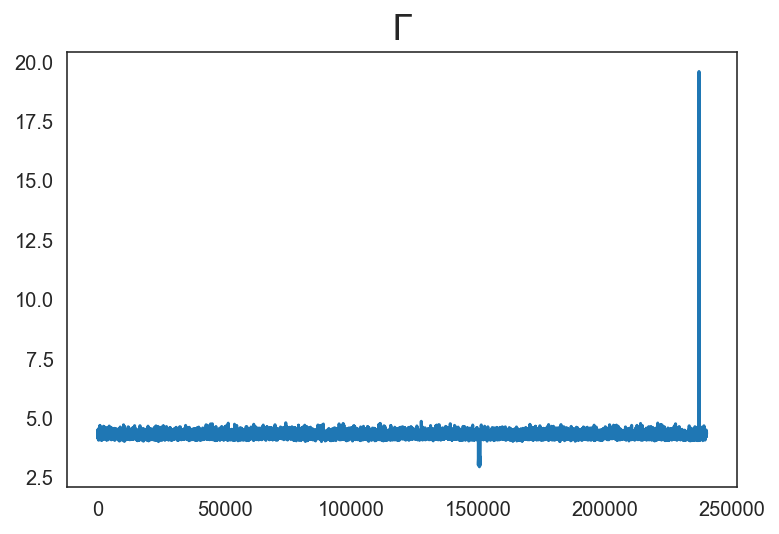

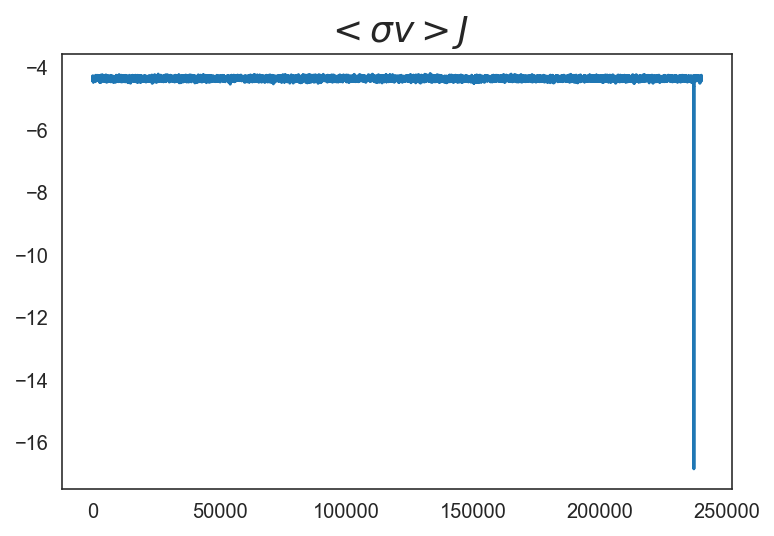

In [19]:
plt.figure()
plt.title(r'$\Gamma$',fontsize=18)
plt.plot(sampler.flatchain[:,0])
plt.figure()
plt.title(r'$<\sigma v> J$',fontsize=18)
plt.plot(sampler.flatchain[:,1])

In [20]:
labels = [r'$m_{\chi}$',r'$\left \langle \sigma v\right \rangle J$',
          r'$log_{10}(N_{s2})$',r'$\alpha_{s2}$']

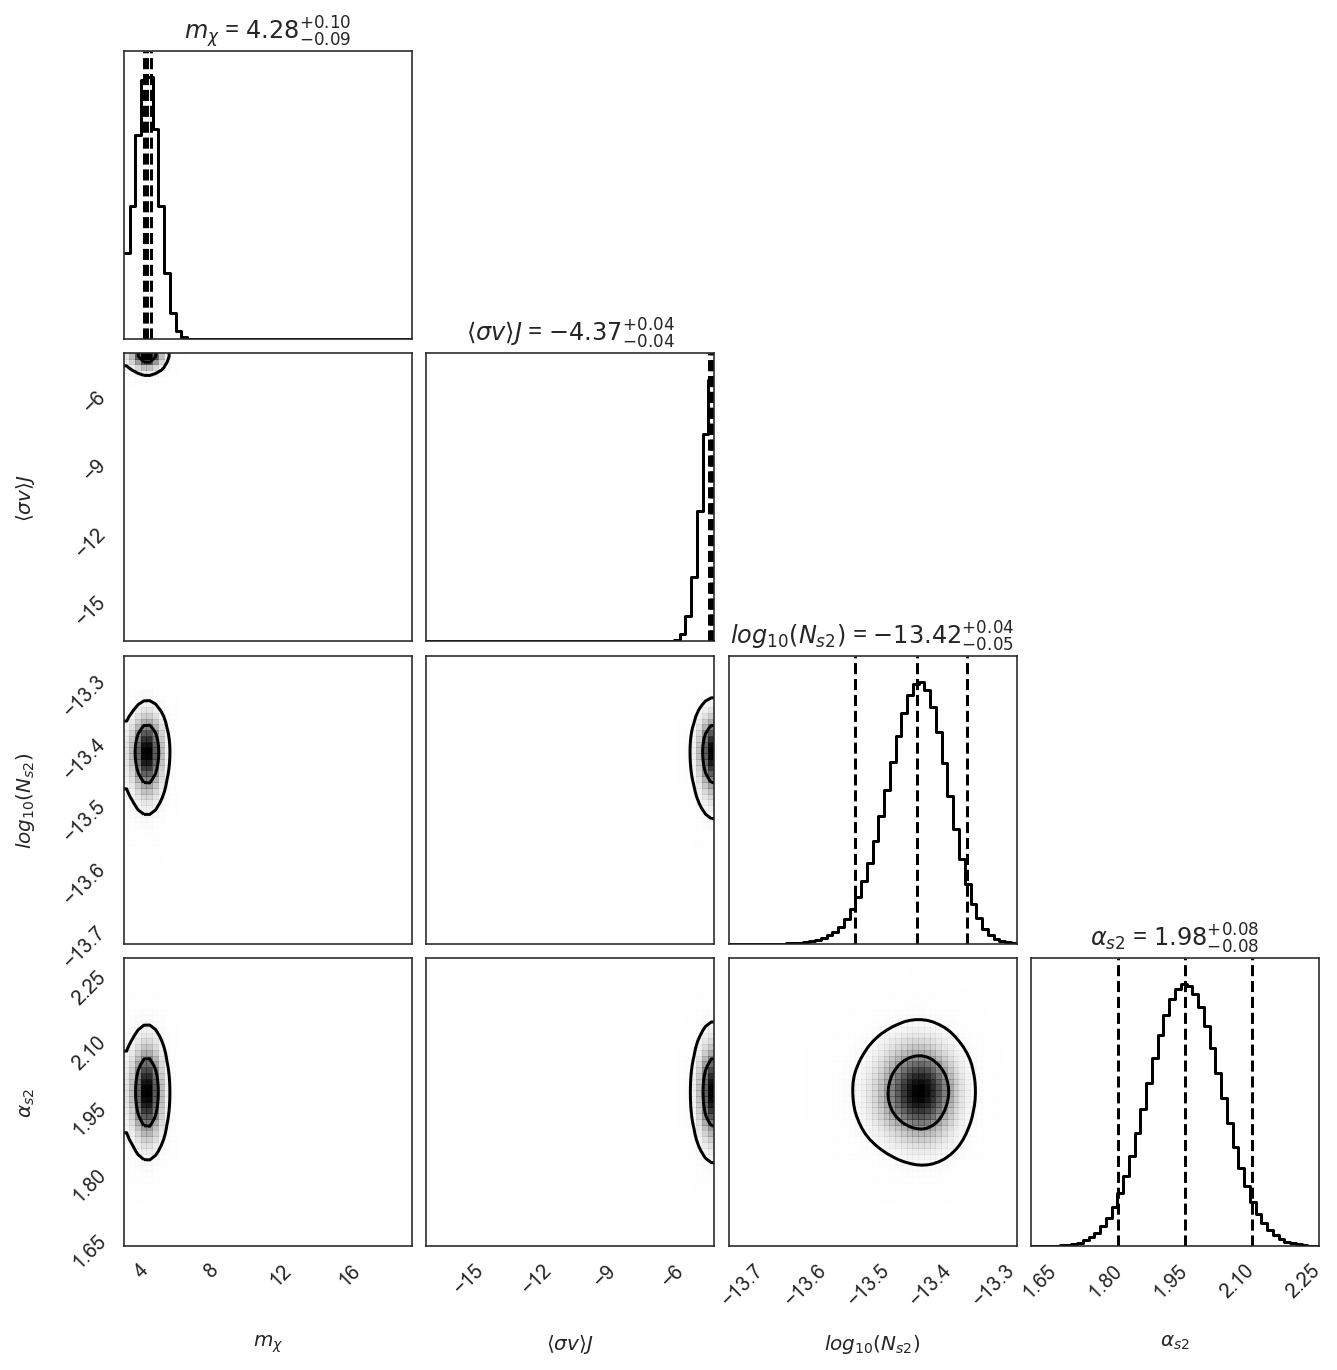

In [21]:
fig = corner.corner(sampler.flatchain,bins=50,labels=labels,plot_datapoints=False,smooth=2., 
                    smooth1d=2,levels=(1.-np.exp(-0.5),1.-np.exp(-2.)),quantiles=[.025,0.5,0.975],show_titles=True);

In [22]:
np.savetxt('../chains/DM_1D_mu_0.15_P8R3.dat',sampler.flatchain)